# Milestone Project 2: SkimLit

In [1]:
import tensorflow as tf

In [2]:
tf.keras.Sequential()

## Get Data

In [3]:
!git clone https://github.com/Franck-Dernoncourt/pubmed-rct.git
!ls pubmed-rct

fatal: destination path 'pubmed-rct' already exists and is not an empty directory.
PubMed_200k_RCT
PubMed_200k_RCT_numbers_replaced_with_at_sign
PubMed_20k_RCT
PubMed_20k_RCT_numbers_replaced_with_at_sign
README.md


In [4]:
# Check what files are in the Pubmed 20k dataset
!ls pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/

dev.txt  test.txt  train.txt


In [5]:
# Start our experiments usign the 20k dataset
data_dir = "/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/"

In [6]:
import os
filenames = [data_dir + file for file in os.listdir(data_dir)]
filenames

['/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/dev.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/test.txt',
 '/content/pubmed-rct/PubMed_20k_RCT_numbers_replaced_with_at_sign/train.txt']

## Preprocess data
Now we've gott some text data , its time to become one with it...

In [7]:
# Create function to read the lines of a document
def get_lines(filename):
  """
    Reads filename (a text filename) and returns the lines of a text as a list

    Args:
      filename (str): a string containing the target filepath
  """
  with open(filename, 'r') as f:
    return f.readlines()
  

In [8]:
# Lets read in the training lines
train_lines = get_lines(data_dir + "train.txt")
train_lines[:10]

['###24293578\n',
 'OBJECTIVE\tTo investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( OA ) .\n',
 'METHODS\tA total of @ patients with primary knee OA were randomized @:@ ; @ received @ mg/day of prednisolone and @ received placebo for @ weeks .\n',
 'METHODS\tOutcome measures included pain reduction and improvement in function scores and systemic inflammation markers .\n',
 'METHODS\tPain was assessed using the visual analog pain scale ( @-@ mm ) .\n',
 'METHODS\tSecondary outcome measures included the Western Ontario and McMaster Universities Osteoarthritis Index scores , patient global assessment ( PGA ) of the severity of knee OA , and @-min walk distance ( @MWD ) .\n',
 'METHODS\tSerum levels of interleukin @ ( IL-@ ) , IL-@ , tumor necrosis factor ( TNF ) - , and 

In [9]:
# sentences = []
# labels = []

# for s in train_lines:
#   if "###" in s:
#     pass
#   else:
#     sentence = s.split('\t')
#     if len(sentence) <= 1:
#       pass
#     else:
#       labels.append(sentence[0])
#       sentences.append(sentence[1])

In [10]:
# labels[:5], sentences[:5]

In [11]:
# len(labels), len(sentences)

In [12]:
import pandas as pd
# pd.DataFrame({'text': sentences, 'label': labels})

In [13]:
def preprocess_text_with_line_numbers(filename):
  """
    Returns a list of dictionaries of abstract line data.
    Takes in filename, reads it contents and sorts thourgh each line,
    extracting things like the t arget label, the text of  the sentence, 
    how many sentences are in the current abstract and what sentence
  """
  input_lines = get_lines(filename) # gett all lines from list
  abstract_lines = "" # create an empty abstract
  abstract_samples = [] # create an empty list of abstracts
  
  # Loop through each line in target file
  for line in input_lines:
    if line.startswith("###"):
      abstract_id = line
      abstract_lines = ""
    elif line.isspace():
      abstract_line_split = abstract_lines.splitlines() # split abstract into separate lines

      # Iterate through each line in a single abstract
      for abstract_line_number, abstract_line in enumerate(abstract_line_split):
        line_data = {}
        target_text_split = abstract_line.split('\t')

        line_data['target'] = target_text_split[0] # get target label
        line_data['text'] = target_text_split[1].lower() # get target text and lower it
        line_data['line_number'] = abstract_line_number
        line_data['total_lines'] = len(abstract_line_split) - 1
        abstract_samples.append(line_data)
    else:
      abstract_lines += line
  return abstract_samples 

In [14]:
# Get data from file and preprocess it
train_samples = preprocess_text_with_line_numbers(data_dir + "train.txt")
val_samples = preprocess_text_with_line_numbers(data_dir + "dev.txt")
test_samples = preprocess_text_with_line_numbers(data_dir + "test.txt")

In [15]:
len(train_samples), len(val_samples), len(test_samples)

(180040, 30212, 30135)

In [16]:
import pandas as pd

train_df = pd.DataFrame(train_samples)
val_df = pd.DataFrame(val_samples)
test_df = pd.DataFrame(test_samples)

train_df.head(20)

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11
5,METHODS,"serum levels of interleukin @ ( il-@ ) , il-@ ...",5,11
6,RESULTS,there was a clinically relevant reduction in t...,6,11
7,RESULTS,the mean difference between treatment arms ( @...,7,11
8,RESULTS,"further , there was a clinically relevant redu...",8,11
9,RESULTS,these differences remained significant at @ we...,9,11


In [17]:
# Distribution of labels in training data
train_df['target'].value_counts()

METHODS        59353
RESULTS        57953
CONCLUSIONS    27168
BACKGROUND     21727
OBJECTIVE      13839
Name: target, dtype: int64

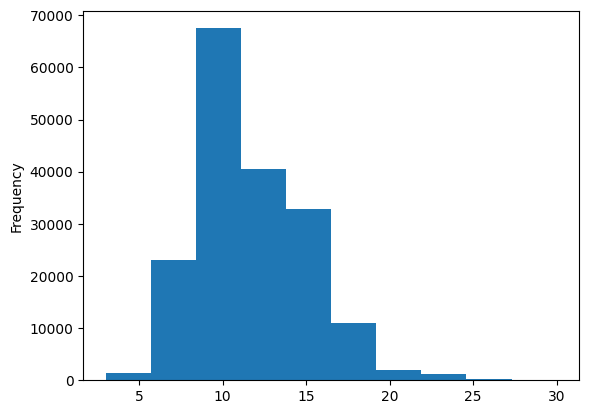

In [18]:
# Check the length of different lines
train_df.total_lines.plot.hist();

### Get list of sentences

In [19]:
# convert abstract lines into lists
train_sentences = train_df['text'].tolist()
val_sentences = val_df['text'].tolist()
test_sentences = test_df['text'].tolist()

In [20]:
train_sentences[0]

'to investigate the efficacy of @ weeks of daily low-dose oral prednisolone in improving pain , mobility , and systemic low-grade inflammation in the short term and whether the effect would be sustained at @ weeks in older adults with moderate to severe knee osteoarthritis ( oa ) .'

## Make Numeric Labels 

### One Hot Encoded Labels

In [21]:
# One hot encode labels
from sklearn.preprocessing import OneHotEncoder
one_hot_encoder = OneHotEncoder(sparse=False)
train_labels_one_hot = one_hot_encoder.fit_transform(train_df['target'].to_numpy().reshape(-1,1 ))
val_labels_one_hot = one_hot_encoder.transform(val_df['target'].to_numpy().reshape(-1,1 ))
test_labels_one_hot = one_hot_encoder.transform(test_df['target'].to_numpy().reshape(-1, 1))


/usr/local/lib/python3.10/dist-packages/sklearn/preprocessing/_encoders.py:868: FutureWarning: `sparse` was renamed to `sparse_output` in version 1.2 and will be removed in 1.4. `sparse_output` is ignored unless you leave `sparse` to its default value.
  warnings.warn(


In [22]:
train_labels_one_hot[:3]

array([[0., 0., 0., 1., 0.],
       [0., 0., 1., 0., 0.],
       [0., 0., 1., 0., 0.]])

### Label Encoder Encoded Labels

In [23]:
# Extract labels ('target' columns) and encode them into integers
from sklearn.preprocessing import LabelEncoder

label_encoder = LabelEncoder()
train_labels_encoded = label_encoder.fit_transform(train_df['target'].to_numpy())
val_labels_encoded = label_encoder.transform(val_df['target'].to_numpy())
test_labesl_encoded = label_encoder.transform(test_df['target'].to_numpy())

In [24]:
train_labels_encoded[:3]

array([3, 2, 2])

In [25]:
# Get class names and number of classes 
num_classes = len(label_encoder.classes_)
class_names = label_encoder.classes_
num_classes, class_names

(5,
 array(['BACKGROUND', 'CONCLUSIONS', 'METHODS', 'OBJECTIVE', 'RESULTS'],
       dtype=object))

## Build Models

## Model 0 : Baseline Naive Bayes with TF-IDF

In [26]:
# Importing modules
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.pipeline import Pipeline 

# Create tokenization and modelling pipeline

model_0 = Pipeline([
    ('tfidf', TfidfVectorizer()),
    ('clf', MultinomialNB())
])

# Fit the pipeline to the training data
model_0.fit(train_sentences, train_labels_encoded)

Pipeline(steps=[('tfidf', TfidfVectorizer()), ('clf', MultinomialNB())])

In [27]:
# Evaluate our  baseline model
baseline_score = model_0.score(val_sentences, val_labels_encoded)
print(f"Our baseline model achieves an accuracy of :  {baseline_score*100:.2f}%")

Our baseline model achieves an accuracy of :  72.18%


In [28]:
# Make prediction using our baseline model
baseline_preds = model_0.predict(val_sentences)

In [29]:
baseline_preds[:5]

array([4, 1, 3, 2, 2])

In [30]:
# Accuracy Result
from sklearn.metrics import classification_report

model_0_result = classification_report(baseline_preds, val_labels_encoded)
print(model_0_result)

              precision    recall  f1-score   support

           0       0.49      0.66      0.56      2568
           1       0.59      0.65      0.61      4159
           2       0.87      0.72      0.79     11970
           3       0.14      0.75      0.23       435
           4       0.86      0.76      0.81     11080

    accuracy                           0.72     30212
   macro avg       0.59      0.71      0.60     30212
weighted avg       0.78      0.72      0.74     30212



## Helper Function

In [31]:
!wget https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py

--2023-05-28 10:55:02--  https://raw.githubusercontent.com/mrdbourke/tensorflow-deep-learning/main/extras/helper_functions.py
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 10246 (10K) [text/plain]
Saving to: ‘helper_functions.py.3’

helper_functions.py 100%[===================>]  10.01K  --.-KB/s    in 0s      

2023-05-28 10:55:03 (75.3 MB/s) - ‘helper_functions.py.3’ saved [10246/10246]



In [32]:
from helper_functions import calculate_results

# Calculate baseline retuls
baseline_results = calculate_results(baseline_preds, val_labels_encoded)
baseline_results

{'accuracy': 72.1832384482987,
 'precision': 0.7835634520695112,
 'recall': 0.7218323844829869,
 'f1': 0.7447397336209445}

## Preparing our data for Deep Sequence models

### Text Vectorization

In [33]:
import tensorflow as tf
import numpy as np
from tensorflow.keras import layers

# How long is each sentence on average?
sent_lens = [len(sentence.split()) for sentence in train_sentences]

avg_sent_len = np.mean(sent_lens)

(array([1.73668e+05, 6.16200e+03, 1.78000e+02, 2.70000e+01, 5.00000e+00]),
 array([  1.,  60., 119., 178., 237., 296.]),
 <BarContainer object of 5 artists>)

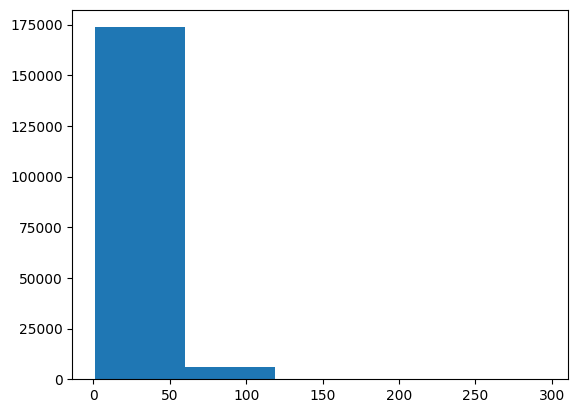

In [34]:
# Whats the distribution look like?
import matplotlib.pyplot as plt
plt.hist(sent_lens, bins=5)

In [35]:
# How long of a sentence length covers 95% of examples?
output_seq_len = int(np.percentile(sent_lens, 95))

output_seq_len

55

In [36]:
# Maximumg sequence length in the training set
max(sent_lens)

296

In [37]:
# SETUP TEXT VECTORIZATION VARIABLES
from tensorflow.keras.layers.experimental.preprocessing import TextVectorization

max_vocab_length = 68000 # based on PubMed paper
max_length = output_seq_len

text_vectorizer = TextVectorization(max_tokens=max_vocab_length,
                                    standardize='lower_and_strip_punctuation',
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=max_length,
                                    pad_to_max_tokens=True)



In [38]:
# Fit the text vectorizer to the training sets
text_vectorizer.adapt(train_sentences)

In [39]:
# Create a sample sentence and tokenize it
# Choose a random sentence from the training dataset and tokenize it
import random

random_sentence = random.choice(train_sentences)
print(f"Original text:\n {random_sentence}")
print(f"\n\nVectorized version: \n{text_vectorizer([random_sentence])}")

Original text:
 to examine gender disparities in cognitive functioning in india and the extent to which education explains this disparity in later life .


Vectorized version: 
[[    6   534  1005  4717     5   301   790     5  2861     3     2  1387
      6   126   433 23178    23  8102     5   869   195     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0     0     0     0     0     0
      0     0     0     0     0     0     0]]


In [40]:
# Get the unique words in the vocabulary 
words_in_vocab = text_vectorizer.get_vocabulary() # get all of the unique words
top_5_words = words_in_vocab[:5] # get the most common words
bottom_5_words = words_in_vocab[-5:] # get the least common words

print(f"Number of words in vocab : {len(words_in_vocab)}")
print(f"5 Most common words: {top_5_words}")
print(f"5 Leastt common words: {bottom_5_words}")

Number of words in vocab : 64841
5 Most common words: ['', '[UNK]', 'the', 'and', 'of']
5 Leastt common words: ['aainduced', 'aaigroup', 'aachener', 'aachen', 'aaacp']


In [41]:
# Get the config of our text vectorizer
text_vectorizer.get_config()

{'name': 'text_vectorization',
 'trainable': True,
 'dtype': 'string',
 'batch_input_shape': (None,),
 'max_tokens': 68000,
 'standardize': 'lower_and_strip_punctuation',
 'split': 'whitespace',
 'ngrams': None,
 'output_mode': 'int',
 'output_sequence_length': 55,
 'pad_to_max_tokens': True,
 'sparse': False,
 'ragged': False,
 'vocabulary': None,
 'idf_weights': None,
 'encoding': 'utf-8',
 'vocabulary_size': 64841}

### Embedding Layer

In [42]:
# Create an embedding layer

embedding = layers.Embedding(input_dim=len(words_in_vocab),
                             output_dim=512,
                             mask_zero=True, # use masking
                             input_length=max_length)

embedding

In [43]:
# Get random sentence from the training set
print(f"Original text: \n {random_sentence}")
print(f"Embedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
sample_embed = embedding(text_vectorizer([random_sentence]))
print(sample_embed)
print(f"Shape: {sample_embed.shape}")

Original text: 
 to examine gender disparities in cognitive functioning in india and the extent to which education explains this disparity in later life .
Embedded version:
tf.Tensor(
[[[ 0.00379735  0.01651964 -0.02266512 ...  0.0451239   0.01726434
    0.04517938]
  [-0.00890668  0.04703777  0.04686869 ... -0.04641283 -0.00194044
    0.03354461]
  [ 0.04222227  0.04236007 -0.04865475 ... -0.00218268 -0.04655346
    0.04142201]
  ...
  [-0.03181499 -0.01250932 -0.00933985 ... -0.02839123  0.03404549
    0.01121131]
  [-0.03181499 -0.01250932 -0.00933985 ... -0.02839123  0.03404549
    0.01121131]
  [-0.03181499 -0.01250932 -0.00933985 ... -0.02839123  0.03404549
    0.01121131]]], shape=(1, 55, 512), dtype=float32)
Shape: (1, 55, 512)


## Preparing Datasets
* Creating datasets (making sure our data loads as fast as possible)

We're going to set up our data to run as fast as possible with the TensorFlow `tf.data` API 

**Resources**:
* https://www.tensorflow.org/guide/data_performance
* https://www.tensorflow.org/guide/data

In [44]:
# Turn our data into TensorFlow datasets
train_dataset = tf.data.Dataset.from_tensor_slices((train_sentences, train_labels_one_hot))
valid_dataset = tf.data.Dataset.from_tensor_slices((val_sentences, val_labels_one_hot))
test_dataset = tf.data.Dataset.from_tensor_slices((test_sentences, test_labels_one_hot))

In [45]:
# Take the tensorSliceDataset's and turn them into prefetched datasets
train_dataset = train_dataset.batch(32).prefetch(tf.data.AUTOTUNE) # order is important so we dont have to shuffle in terms of PubMed Skimlit
valid_dataset = valid_dataset.batch(32).prefetch(tf.data.AUTOTUNE)
test_dataset = test_dataset.batch(32).prefetch(tf.data.AUTOTUNE)

train_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Model 1: Conv1D

In [46]:
# Create tensorboard callback
from helper_functions import create_tensorboard_callback

# Create directory to save TensorBoard logs
SAVE_DIR = "model_logs"

In [47]:
# Build model with the functional API
from tensorflow.keras import layers

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = text_vectorizer(inputs)
x = embedding(x)
x = layers.Conv1D(32, 3, activation='relu')(x)
x = layers.GlobalMaxPooling1D()(x)
outputs = layers.Dense(5, activation='softmax')(x)

model_1 = tf.keras.Model(inputs, outputs)

# Summary
model_1.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization (TextVec  (None, 55)               0         
 torization)                                                     
                                                                 
 embedding (Embedding)       (None, 55, 512)           33198592  
                                                                 
 conv1d (Conv1D)             (None, 53, 32)            49184     
                                                                 
 global_max_pooling1d (Globa  (None, 32)               0         
 lMaxPooling1D)                                                  
                                                                 
 dense (Dense)               (None, 5)                 165   

In [48]:
# Compile the model
model_1.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [49]:
# Dataset we have in the train_dataset
len(train_dataset)

5627

In [50]:
# Num batches * len(train_dataset)
32 * len(train_dataset)

180064

In [51]:
# #  Fit the model
# model_1_history = model_1.fit(train_dataset,
#                               epochs=10,
#                               validation_data=valid_dataset,
#                               callbacks=[create_tensorboard_callback(SAVE_DIR,
#                                                                      'model_1_conv1d')])

#  Fit the model
model_1_history = model_1.fit(train_dataset,
                              epochs=10,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_1_conv1d')])

Saving TensorBoard log files to: model_logs/model_1_conv1d/20230528-105535
Epoch 1/10
562/562 [==============================] - 46s 74ms/step - loss: 0.7913 - accuracy: 0.7028 - val_loss: 0.5945 - val_accuracy: 0.7819
Epoch 2/10
562/562 [==============================] - 12s 22ms/step - loss: 0.5940 - accuracy: 0.7815 - val_loss: 0.5629 - val_accuracy: 0.7906
Epoch 3/10
562/562 [==============================] - 10s 17ms/step - loss: 0.5611 - accuracy: 0.7938 - val_loss: 0.5391 - val_accuracy: 0.8082
Epoch 4/10
562/562 [==============================] - 11s 19ms/step - loss: 0.5459 - accuracy: 0.7976 - val_loss: 0.5411 - val_accuracy: 0.8015
Epoch 5/10
562/562 [==============================] - 11s 19ms/step - loss: 0.5502 - accuracy: 0.8009 - val_loss: 0.5112 - val_accuracy: 0.8105
Epoch 6/10
562/562 [==============================] - 10s 18ms/step - loss: 0.5457 - accuracy: 0.7977 - val_loss: 0.5109 - val_accuracy: 0.8128
Epoch 7/10
562/562 [==============================] - 10s 18m

<Axes: >

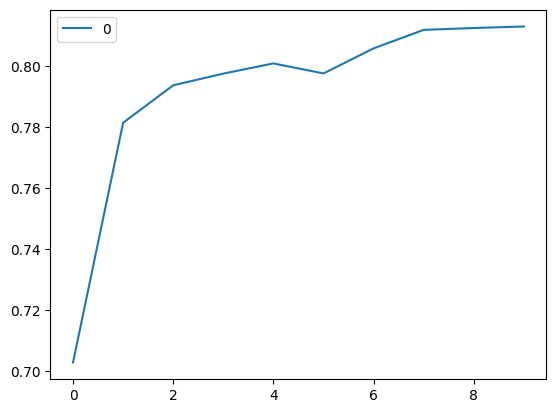

In [52]:
pd.DataFrame(model_1_history.history['accuracy']).plot()

In [53]:
# Evaluate on the whole validation dataset
model_1.evaluate(valid_dataset)

945/945 [==============================] - 5s 5ms/step - loss: 0.5010 - accuracy: 0.8135


[0.5010484457015991, 0.8134515881538391]

In [54]:
# Make predictions
model_1_pred_probs = model_1.predict(valid_dataset)

model_1_preds = tf.argmax(model_1_pred_probs, axis=1)

945/945 [==============================] - 3s 3ms/step


In [55]:
model_1_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 3, 2, 2])>

In [56]:
# Calculate model_1 results
model_1_results = calculate_results(model_1_preds, val_labels_encoded)

In [57]:
model_1_results

{'accuracy': 81.34516086323316,
 'precision': 0.8208270979137688,
 'recall': 0.8134516086323316,
 'f1': 0.8162286298763325}

## Model 2 : Pretrained TensorFlow Hub Embedding (USE Transformer)


### USE: Transformer

In [58]:
import tensorflow_hub as hub

# USE: Transfomer
embed = hub.load("https://tfhub.dev/google/universal-sentence-encoder/4")
embed_samples = embed(["There's a flood in my street!"])
print(embed_samples)

tf.Tensor(
[[-0.01157027  0.02485911  0.02878049 -0.01271501  0.0397154   0.08827761
   0.02680985  0.05589838 -0.01068731 -0.0059729   0.00639323 -0.01819521
   0.00030817  0.09105889  0.05874642 -0.03180628  0.01512472 -0.05162928
   0.00991366 -0.06865346 -0.04209308  0.0267898   0.03011007  0.00321065
  -0.00337969 -0.04787356  0.02266722 -0.00985928 -0.04063612 -0.01292093
  -0.04666385  0.05630299 -0.03949254  0.00517688  0.02495828 -0.07014439
   0.02871511  0.04947681 -0.00633974 -0.08960193  0.02807117 -0.00808362
  -0.01360602  0.05998651 -0.10361787 -0.05195372  0.00232956 -0.02332529
  -0.03758107  0.0332773  -0.00430601 -0.05894248 -0.06101279 -0.02220004
  -0.01575764 -0.00474412 -0.03515064 -0.04440377 -0.04174355  0.04943502
  -0.02740931 -0.04133103  0.01634346 -0.03713681  0.0739521  -0.0065924
  -0.0694331  -0.00361752  0.08656701  0.07717377 -0.06633057  0.02086627
   0.06676425  0.00982105  0.01410715  0.07672231  0.05026632  0.02969933
  -0.01391871  0.06082515  0

In [59]:
# Build TensorFlow Hub pretrained model embeddings
sentence_encoder_layer_transformer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder/4",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE')

 

In [60]:
# Create model using the Sequential API

model_2 = tf.keras.Sequential([
    sentence_encoder_layer_transformer,
    layers.Dense(5, activation='softmax')
])

# Summary
model_2.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 USE (KerasLayer)            (None, 512)               256797824 
                                                                 
 dense_1 (Dense)             (None, 5)                 2565      
                                                                 
Total params: 256,800,389
Trainable params: 2,565
Non-trainable params: 256,797,824
_________________________________________________________________


In [61]:
# Compile the model
model_2.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

In [62]:
model_2_history = model_2.fit(train_dataset,
                              epochs=10,
                              steps_per_epoch=int(0.1*len(train_dataset)),
                              validation_data=valid_dataset,
                              validation_steps=int(0.1*len(valid_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_2_conv1d')])

Saving TensorBoard log files to: model_logs/model_2_conv1d/20230528-105813
Epoch 1/10
562/562 [==============================] - 14s 20ms/step - loss: 1.2641 - accuracy: 0.5413 - val_loss: 1.0866 - val_accuracy: 0.6011
Epoch 2/10
562/562 [==============================] - 12s 21ms/step - loss: 1.0129 - accuracy: 0.6254 - val_loss: 0.9556 - val_accuracy: 0.6519
Epoch 3/10
562/562 [==============================] - 9s 16ms/step - loss: 0.9315 - accuracy: 0.6574 - val_loss: 0.8955 - val_accuracy: 0.6745
Epoch 4/10
562/562 [==============================] - 11s 20ms/step - loss: 0.8740 - accuracy: 0.6787 - val_loss: 0.8623 - val_accuracy: 0.6782
Epoch 5/10
562/562 [==============================] - 11s 19ms/step - loss: 0.8635 - accuracy: 0.6764 - val_loss: 0.8408 - val_accuracy: 0.6868
Epoch 6/10
562/562 [==============================] - 9s 16ms/step - loss: 0.8519 - accuracy: 0.6830 - val_loss: 0.8270 - val_accuracy: 0.6905
Epoch 7/10
562/562 [==============================] - 10s 18ms/

In [63]:
# Evalute model 2
model_2.evaluate(valid_dataset)

945/945 [==============================] - 14s 15ms/step - loss: 0.7951 - accuracy: 0.6995


[0.7951490879058838, 0.699523389339447]

In [64]:
# Make predictions
model_2_pred_probs = model_2.predict(valid_dataset)

945/945 [==============================] - 14s 14ms/step


In [65]:
model_2_preds = tf.argmax(model_2_pred_probs, axis=1)
model_2_preds[:5]

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 1, 3, 2, 4])>

In [66]:
model_2_results = calculate_results(model_2_preds, 
                                    val_labels_encoded)
model_2_results

{'accuracy': 69.9523368198067,
 'precision': 0.7158738456146624,
 'recall': 0.699523368198067,
 'f1': 0.7054462709463207}

In [67]:
sample_predict = model_2.predict(['the model achieved state-of-the-art accuracy performance compared to other models'])

1/1 [==============================] - 0s 400ms/step


In [68]:
tf.argmax(sample_predict)

<tf.Tensor: shape=(5,), dtype=int64, numpy=array([0, 0, 0, 0, 0])>

In [69]:
class_names[tf.argmax(sample_predict, axis=1)]

<ipython-input-69-2aec8ea03ff4>:1: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  class_names[tf.argmax(sample_predict, axis=1)]


'RESULTS'

### Character level embeddings

In [70]:
# Make functions to split sentences into characters
def split_chars(text):
  return " ".join(list(text))

In [71]:
split_chars("i love TensorFlow")

'i   l o v e   T e n s o r F l o w'

In [72]:
# Split sequence-level data splits into character-level data splits
train_chars = [split_chars(sentence) for sentence in train_sentences]
val_chars = [split_chars(sentence) for sentence in val_sentences]
test_chars = [split_chars(sentence) for sentence in test_sentences]

In [73]:
# What's average character length?
char_lens = [len(sentence) for sentence in train_sentences]
mean_char_len = np.mean(char_lens)
mean_char_len

149.3662574983337

(array([1.41175e+05, 3.71110e+04, 1.60000e+03, 1.27000e+02, 2.10000e+01,
        5.00000e+00, 1.00000e+00]),
 array([1.00000000e+00, 1.98857143e+02, 3.96714286e+02, 5.94571429e+02,
        7.92428571e+02, 9.90285714e+02, 1.18814286e+03, 1.38600000e+03]),
 <BarContainer object of 7 artists>)

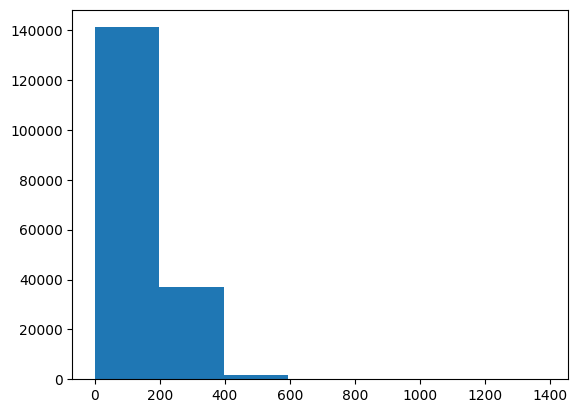

In [74]:
# Check the distribution of our sequences 
import matplotlib.pyplot as plt
plt.hist(char_lens, bins=7)

In [75]:
# How long of a sentence length covers 95% of examples?
output_seq_char_len = int(np.percentile(char_lens, 95))

output_seq_char_len

290

In [76]:
# Get all keyboard characters to get generalized length of character 
import string

alphabet = string.ascii_lowercase + string.digits + string.punctuation
alphabet

'abcdefghijklmnopqrstuvwxyz0123456789!"#$%&\'()*+,-./:;<=>?@[\\]^_`{|}~'

In [77]:
# Craete char-level token vectorizer instance
NUM_CHAR_TOKENS = len(alphabet) + 2 # include space and <OOV> token 

char_vectorizer =  TextVectorization(max_tokens=NUM_CHAR_TOKENS,
                                    standardize='lower_and_strip_punctuation', # set to None to include punctuation
                                    split="whitespace",
                                    ngrams=None,
                                    output_mode='int',
                                    output_sequence_length=output_seq_char_len, 
                                    pad_to_max_tokens=True)

In [78]:
# Fit to train character sequences
char_vectorizer.adapt(train_chars)

In [79]:
# Check character vocab stats
char_vocab = char_vectorizer.get_vocabulary()
print(char_vocab)

['', '[UNK]', 'e', 't', 'i', 'a', 'n', 'o', 'r', 's', 'd', 'c', 'l', 'h', 'p', 'm', 'u', 'f', 'g', 'y', 'w', 'v', 'b', 'k', 'x', 'z', 'q', 'j']


In [80]:
# Test our character vectorizer

import random

random_sentence = random.choice(train_chars)
print(f"Original text:\n {random_sentence}")
print(f"\n\nVectorized version: \n{char_vectorizer([random_sentence])}")


Original text:
 s t a f f   t r a i n i n g   i s   a   k e y   c o m p o n e n t   o f   m u l t i - s t r a t e g y   i n t e r v e n t i o n s   t o   i m p r o v e   i m p l e m e n t a t i o n   o f   e f f e c t i v e   p h y s i c a l   a c t i v i t y   a n d   n u t r i t i o n   p r o m o t i n g   p r a c t i c e s   f o r   o b e s i t y   p r e v e n t i o n   i n   c h i l d c a r e   s e r v i c e s   .


Vectorized version: 
[[ 9  3  5 17 17  3  8  5  4  6  4  6 18  4  9  5 23  2 19 11  7 15 14  7
   6  2  6  3  7 17 15 16 12  3  4  9  3  8  5  3  2 18 19  4  6  3  2  8
  21  2  6  3  4  7  6  9  3  7  4 15 14  8  7 21  2  4 15 14 12  2 15  2
   6  3  5  3  4  7  6  7 17  2 17 17  2 11  3  4 21  2 14 13 19  9  4 11
   5 12  5 11  3  4 21  4  3 19  5  6 10  6 16  3  8  4  3  4  7  6 14  8
   7 15  7  3  4  6 18 14  8  5 11  3  4 11  2  9 17  7  8  7 22  2  9  4
   3 19 14  8  2 21  2  6  3  4  7  6  4  6 11 13  4 12 10 11  5  8  2  9
   2  8 21  4 11  2  9  0  0  0  0  0

### Create character-level embedding

In [81]:
# Create char embedding
char_embedding = tf.keras.layers.Embedding(input_dim=len(char_vocab),
                                           output_dim=25, # size of char embedding in paper arxiv.org/pdf/1612
                                           mask_zero=True,
                                           )

In [82]:
# Get random sentence from the training set
print(f"Original text: \n {random_sentence}")
print(f"Embedded version:")

# Embed the random sentence (turn it into dense vectors of fixed size)
char_sample_embed = char_embedding(char_vectorizer([random_sentence]))
print(char_sample_embed)
print(f"Shape: {char_sample_embed.shape}")
print(f"Length of vocab : {len(char_vocab)}")

Original text: 
 s t a f f   t r a i n i n g   i s   a   k e y   c o m p o n e n t   o f   m u l t i - s t r a t e g y   i n t e r v e n t i o n s   t o   i m p r o v e   i m p l e m e n t a t i o n   o f   e f f e c t i v e   p h y s i c a l   a c t i v i t y   a n d   n u t r i t i o n   p r o m o t i n g   p r a c t i c e s   f o r   o b e s i t y   p r e v e n t i o n   i n   c h i l d c a r e   s e r v i c e s   .
Embedded version:
tf.Tensor(
[[[ 0.04492924  0.03301631 -0.02977539 ... -0.02457538  0.02273263
   -0.04543545]
  [ 0.03408879 -0.01504285  0.01588247 ... -0.02172062 -0.02758133
   -0.03573354]
  [ 0.02987761 -0.03872121 -0.00471248 ...  0.01729229 -0.0204657
    0.01691991]
  ...
  [-0.02053386 -0.04986891 -0.03405678 ...  0.04133907  0.02197525
    0.04024619]
  [-0.02053386 -0.04986891 -0.03405678 ...  0.04133907  0.02197525
    0.04024619]
  [-0.02053386 -0.04986891 -0.03405678 ...  0.04133907  0.02197525
    0.04024619]]], shape=(1, 290, 25), dtype=float32)
Shape: 

### Create char level datasets

In [83]:
# Create char level datasets
train_char_dataset = tf.data.Dataset.from_tensor_slices((train_chars, train_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
valid_char_dataset = tf.data.Dataset.from_tensor_slices((val_chars, val_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)
test_char_dataset = tf.data.Dataset.from_tensor_slices((test_chars, test_labels_one_hot)).batch(32).prefetch(tf.data.AUTOTUNE)


In [84]:
train_char_dataset

<_PrefetchDataset element_spec=(TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>


## Model 3: Conv1D with character level embeddings

In [85]:
# Build Model 3

inputs = layers.Input(shape=(1,), dtype=tf.string)
x = char_vectorizer(inputs)
x = char_embedding(x)
x = layers.Conv1D(32, 3, activation='relu')(x)
x = layers.GlobalAveragePooling1D()(x)

outputs = layers.Dense(5, activation='softmax')(x)

model_3 = tf.keras.Model(inputs, outputs)


# Summary
model_3.summary()

Model: "model_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_2 (InputLayer)        [(None, 1)]               0         
                                                                 
 text_vectorization_1 (TextV  (None, 290)              0         
 ectorization)                                                   
                                                                 
 embedding_1 (Embedding)     (None, 290, 25)           700       
                                                                 
 conv1d_1 (Conv1D)           (None, 288, 32)           2432      
                                                                 
 global_average_pooling1d (G  (None, 32)               0         
 lobalAveragePooling1D)                                          
                                                                 
 dense_2 (Dense)             (None, 5)                 165 

In [86]:
# Compile the model
model_3.compile(loss='categorical_crossentropy', optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [87]:
# Fit the model
model_3_history = model_3.fit(train_char_dataset,
                              epochs=10,
                              steps_per_epoch = int(0.1 * len(train_char_dataset)),
                              validation_data=valid_char_dataset,
                              validation_steps=int(0.1 * len(valid_char_dataset)),
                              callbacks=[create_tensorboard_callback(SAVE_DIR,
                                                                     'model_3_conv1d')])

Saving TensorBoard log files to: model_logs/model_3_conv1d/20230528-110138
Epoch 1/10
562/562 [==============================] - 7s 8ms/step - loss: 1.4737 - accuracy: 0.3374 - val_loss: 1.4432 - val_accuracy: 0.3614
Epoch 2/10
562/562 [==============================] - 4s 7ms/step - loss: 1.4028 - accuracy: 0.4140 - val_loss: 1.3635 - val_accuracy: 0.4338
Epoch 3/10
562/562 [==============================] - 6s 10ms/step - loss: 1.3477 - accuracy: 0.4421 - val_loss: 1.3353 - val_accuracy: 0.4345
Epoch 4/10
562/562 [==============================] - 4s 7ms/step - loss: 1.3175 - accuracy: 0.4512 - val_loss: 1.3124 - val_accuracy: 0.4551
Epoch 5/10
562/562 [==============================] - 4s 7ms/step - loss: 1.3111 - accuracy: 0.4478 - val_loss: 1.3010 - val_accuracy: 0.4611
Epoch 6/10
562/562 [==============================] - 6s 10ms/step - loss: 1.3060 - accuracy: 0.4552 - val_loss: 1.3016 - val_accuracy: 0.4558
Epoch 7/10
562/562 [==============================] - 4s 7ms/step - los

In [88]:
# Evaluate model
model_3.evaluate(valid_dataset)

945/945 [==============================] - 4s 4ms/step - loss: 1.4678 - accuracy: 0.3409


[1.4677579402923584, 0.34085792303085327]

In [89]:
model_3_pred_probs = model_3.predict(valid_dataset)

945/945 [==============================] - 3s 3ms/step


In [90]:
model_3_preds = tf.argmax(model_3_pred_probs, axis=1)

In [91]:
model_3_preds[:3]

<tf.Tensor: shape=(3,), dtype=int64, numpy=array([4, 4, 2])>

In [92]:
model_3_results = calculate_results(model_3_preds, val_labels_encoded)

/usr/local/lib/python3.10/dist-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


In [93]:
model_3_results

{'accuracy': 34.08579372434794,
 'precision': 0.9324185016636242,
 'recall': 0.3408579372434794,
 'f1': 0.48018734899616156}

## Model 4 : Combining pretrained token embeddings + characters (hybrid embeddings)

1. Create a token-level embeedding (model)
2. Create a character-level model (with slight modif)
3. Combine 1 & 2 with a concatenate (`layers.Concatenate`)
4. Build a series of output layers on top of 3 similar to Figure 1 and section 4.2 of the paper
5. Construct a model which takes toke nand character-level sequenes as input and produces sequence label probabilities as output

In [94]:
#1. Setup token inputs/model

token_input = layers.Input(shape=[], dtype=tf.string, name="token_input") # USE expects empty lists
token_embeddings =  sentence_encoder_layer_transformer(token_input)
token_output = layers.Dense(128, activation='relu')(token_embeddings) # custom output layer to be concanenated
token_model = tf.keras.Model(token_input, token_output)

#2. Setup char inputs/model
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
x = char_vectorizer(char_inputs)
x = char_embedding(x)
x = layers.Bidirectional(layers.LSTM(24))(x) # bi-LSTM shown in Figure 1 of the paper. 
char_model = tf.keras.Model(char_inputs, x)


#3. Concatenate token and char inputs (create hybrid token embedding)
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output, 
                                                                  char_model.output])

#4. Create output layers - adding in Dropout
combined_dropout = layers.Dropout(0.5)(token_char_concat)
combined_dense = layers.Dense(128, activation='relu')(combined_dropout)
final_dropout = layers.Dropout(0.5)(combined_dense)

output_layer = layers.Dense(5, activation='softmax')(final_dropout)

#5. Construct model with char and token inputs
model_4 = tf.keras.Model(inputs=[token_model.input, char_model.input],
                         outputs=output_layer,
                         )

In [95]:
# Get summary
model_4.summary()

Model: "model_4"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']      

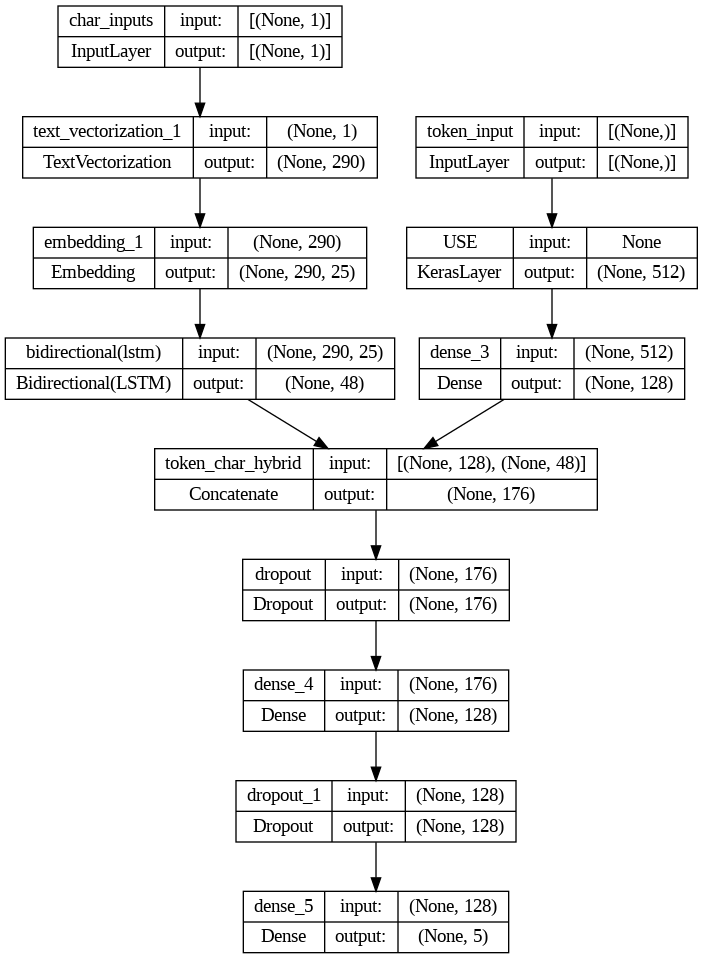

In [96]:
# Plot hybrid token and character model
from tensorflow.keras.utils import plot_model
plot_model(model_4, show_shapes=True)

In [97]:
# Compile the model
model_4.compile(loss='categorical_crossentropy',
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])

### Multi-inputs tf dataset

In [98]:
# Create char and sentences input tf dataset
train_char_token_data = tf.data.Dataset.from_tensor_slices((train_sentences, train_chars))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_dataset = tf.data.Dataset.zip((train_char_token_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Create for validation dataset
val_char_token_data =tf.data.Dataset.from_tensor_slices((val_sentences, val_chars))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_dataset = tf.data.Dataset.zip((val_char_token_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [99]:
# Fit the model
model_4_history = model_4.fit(
    train_char_token_dataset,
    epochs=10,
    steps_per_epoch=int(0.1 * len(train_char_token_dataset)),
    validation_data=val_char_token_dataset,
    validation_steps=int(0.1 * len(val_char_token_dataset))
)

Epoch 1/10
562/562 [==============================] - 50s 69ms/step - loss: 0.9861 - accuracy: 0.6068 - val_loss: 0.7937 - val_accuracy: 0.7015
Epoch 2/10
562/562 [==============================] - 33s 59ms/step - loss: 0.8025 - accuracy: 0.6886 - val_loss: 0.7229 - val_accuracy: 0.7201
Epoch 3/10
562/562 [==============================] - 31s 56ms/step - loss: 0.7818 - accuracy: 0.7012 - val_loss: 0.6976 - val_accuracy: 0.7417
Epoch 4/10
562/562 [==============================] - 37s 66ms/step - loss: 0.7496 - accuracy: 0.7186 - val_loss: 0.6753 - val_accuracy: 0.7487
Epoch 5/10
562/562 [==============================] - 32s 56ms/step - loss: 0.7555 - accuracy: 0.7141 - val_loss: 0.6660 - val_accuracy: 0.7427
Epoch 6/10
562/562 [==============================] - 33s 58ms/step - loss: 0.7528 - accuracy: 0.7135 - val_loss: 0.6558 - val_accuracy: 0.7513
Epoch 7/10
562/562 [==============================] - 38s 67ms/step - loss: 0.7219 - accuracy: 0.7261 - val_loss: 0.6404 - val_accuracy:

In [100]:
# Evaluate one the whole validation dataset
model_4.evaluate(val_char_token_dataset)

945/945 [==============================] - 25s 26ms/step - loss: 0.6273 - accuracy: 0.7616


[0.6272516846656799, 0.76161789894104]

In [101]:
# Make predictions using the totken character model hybrid
model_4_pred_probs = model_4.predict(val_char_token_dataset) # same formatas our data pipeline

model_4_pred_probs

945/945 [==============================] - 27s 26ms/step


array([[5.06983459e-01, 3.43017071e-01, 8.62658315e-04, 1.45117074e-01,
        4.01975540e-03],
       [3.53632778e-01, 5.56955099e-01, 1.07319083e-03, 8.78980085e-02,
        4.40961623e-04],
       [5.02910733e-01, 1.19586596e-02, 2.68598385e-02, 4.53768075e-01,
        4.50270437e-03],
       ...,
       [2.89760683e-05, 5.75064449e-04, 1.12494435e-02, 4.99164298e-06,
        9.88141537e-01],
       [1.49266887e-02, 8.94552618e-02, 1.77284583e-01, 5.08459052e-03,
        7.13248909e-01],
       [8.95296559e-02, 8.72769654e-01, 2.97221430e-02, 2.38675554e-03,
        5.59186796e-03]], dtype=float32)

In [102]:
# Format pred probs into pred
model_4_preds = tf.argmax(model_4_pred_probs, axis=1)
model_4_preds

<tf.Tensor: shape=(30212,), dtype=int64, numpy=array([0, 1, 0, ..., 4, 4, 1])>

In [103]:
# Get results of token-char-hybrid model
from helper_functions import calculate_results


model_4_results = calculate_results(model_4_preds,
                                    val_labels_encoded)
model_4_results

{'accuracy': 76.1617900172117,
 'precision': 0.7736744528263741,
 'recall': 0.7616179001721171,
 'f1': 0.7653319822257468}

## Model 5 : Positional Embeddings via feature engineering

In [104]:
train_df.head()

,target,text,line_number,total_lines
0,OBJECTIVE,to investigate the efficacy of @ weeks of dail...,0,11
1,METHODS,a total of @ patients with primary knee oa wer...,1,11
2,METHODS,outcome measures included pain reduction and i...,2,11
3,METHODS,pain was assessed using the visual analog pain...,3,11
4,METHODS,secondary outcome measures included the wester...,4,11


In [105]:
train_df['line_number'].value_counts()

0     15000
1     15000
2     15000
3     15000
4     14992
5     14949
6     14758
7     14279
8     13346
9     11981
10    10041
11     7892
12     5853
13     4152
14     2835
15     1861
16     1188
17      751
18      462
19      286
20      162
21      101
22       66
23       33
24       22
25       14
26        7
27        4
28        3
29        1
30        1
Name: line_number, dtype: int64

<Axes: ylabel='Frequency'>

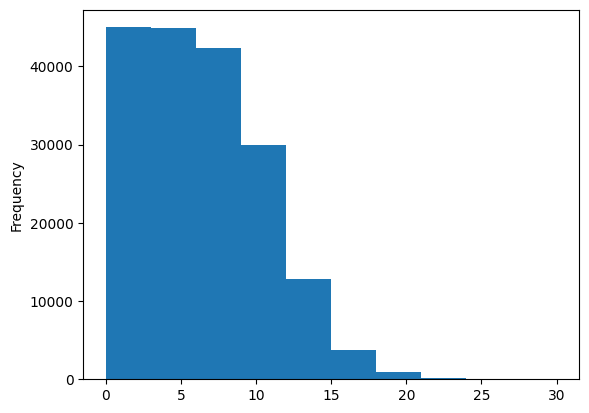

In [106]:
# Check the distribution of "line_number" column
train_df['line_number'].plot.hist()

Must convert to one_hot_encoding so that our feature does makes sense to the model. i.e. 1 and 2 

### Encode line_numbers and total_lines features

In [107]:
#  One hot line_numbers
train_line_numbers_one_hot = tf.one_hot(train_df['line_number'].to_numpy(),  depth=15)
val_line_numbers_one_hot = tf.one_hot(val_df['line_number'].to_numpy(),depth=15)
test_line_numbers_one_hot = tf.one_hot(test_df['line_number'].to_numpy(), depth=15)


train_line_numbers_one_hot[:14], train_line_numbers_one_hot.shape

(<tf.Tensor: shape=(14, 15), dtype=float32, numpy=
 array([[1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0.],
        [1., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0.],
        [0., 1., 0., 0., 0., 0., 0., 0.

In [108]:
train_df['total_lines'].value_counts()

11    24468
10    23639
12    22113
9     19400
13    18438
14    14610
8     12285
15    10768
7      7464
16     7429
17     5202
6      3353
18     3344
19     2480
20     1281
5      1146
21      770
22      759
23      264
4       215
24      200
25      182
26       81
28       58
3        32
30       31
27       28
Name: total_lines, dtype: int64

<Axes: ylabel='Frequency'>

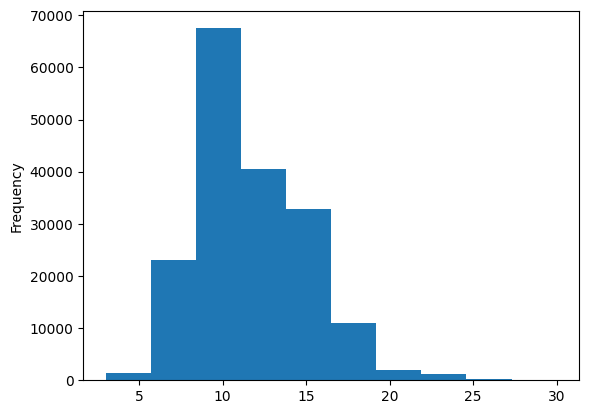

In [109]:
# Check  the  distributions of total lines
train_df.total_lines.plot.hist()

In [110]:
#  Check  the coverage of a 'total_lines' value of 20
np.percentile(train_df.total_lines,  98) # if we cover the '20'values then we will cover  98% of  the data

20.0

In [111]:
# Use TensorFlow to create one-hot-encoded tensors of our 'total_lines' feature
train_total_lines_one_hot = tf.one_hot(train_df['total_lines'].to_numpy(), depth=20)
val_total_lines_one_hot = tf.one_hot(val_df['total_lines'].to_numpy(), depth=20)
test_total_lines_one_hot = tf.one_hot(test_df['total_lines'].to_numpy(), depth=20)
train_total_lines_one_hot[:14], train_total_lines_one_hot.shape

(<tf.Tensor: shape=(14, 20), dtype=float32, numpy=
 array([[0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0., 0., 0., 0.,
         0., 0., 0., 0.],
        [0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 0., 1., 0

### Building a tribrid embedding model

1. Create a token-level  mdoel
2.  create  a character-level   model
3. create a  model for  the line  number feature
4. create  a   model for the 'total_line" feature
5. combinet the outputs of  1  &  2  using `tf.keras.layers.Concatenate`
6. Combine theo utputs of 3, 4, 5  using tf.keras.layers.Concatenate
7. Create an output  layer  to accept the tribried embedding and output label probabilitites
8. combine the inputs of 1,2,3,4 and outputs of  7 into a tf.keras.Model

In [112]:
# 1. Create a token-level model

token_input = layers.Input(shape=[],  dtype=tf.string, name='token_input')
token_embeddings = sentence_encoder_layer_transformer(token_input)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_input, token_output)

# Create a characacter level model 
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
x = char_vectorizer(char_inputs)
x = char_embedding(x)
char_output = layers.Bidirectional(layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs, char_output)

# 3. create a model for the line number feature
line_number_inputs = layers.Input(shape=(15,), name='line_number_inputs')
x = layers.Dense(128, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Create a model for the total line number feature
total_line_inputs = layers.Input(shape=(20,), name='total_line_inputs') 
x = layers.Dense(128, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, x)

# 5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])
# 5.1 Add LSTM layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)

# 6. Combine the  output   of 3,4,5 
final_model_concat = layers.Concatenate(name='token_char_line_tribrid')([line_number_model.output,
                                                                         total_line_model.output,
                                                                         combined_dropout])
# 7.Create an output layer to accept the tribried embedding and output label probabilitites

output_layer = layers.Dense(5, activation='softmax')(final_model_concat)

# 8.combine the inputs of 1,2,3,4 and outputs of 7 into a tf.keras.Model
model_5 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input,
                                 total_line_model.input],
                         outputs=output_layer)

In [113]:
# Summary
model_5.summary()

Model: "model_9"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 char_inputs (InputLayer)       [(None, 1)]          0           []                               
                                                                                                  
 token_input (InputLayer)       [(None,)]            0           []                               
                                                                                                  
 text_vectorization_1 (TextVect  (None, 290)         0           ['char_inputs[0][0]']            
 orization)                                                                                       
                                                                                                  
 USE (KerasLayer)               (None, 512)          256797824   ['token_input[0][0]']      

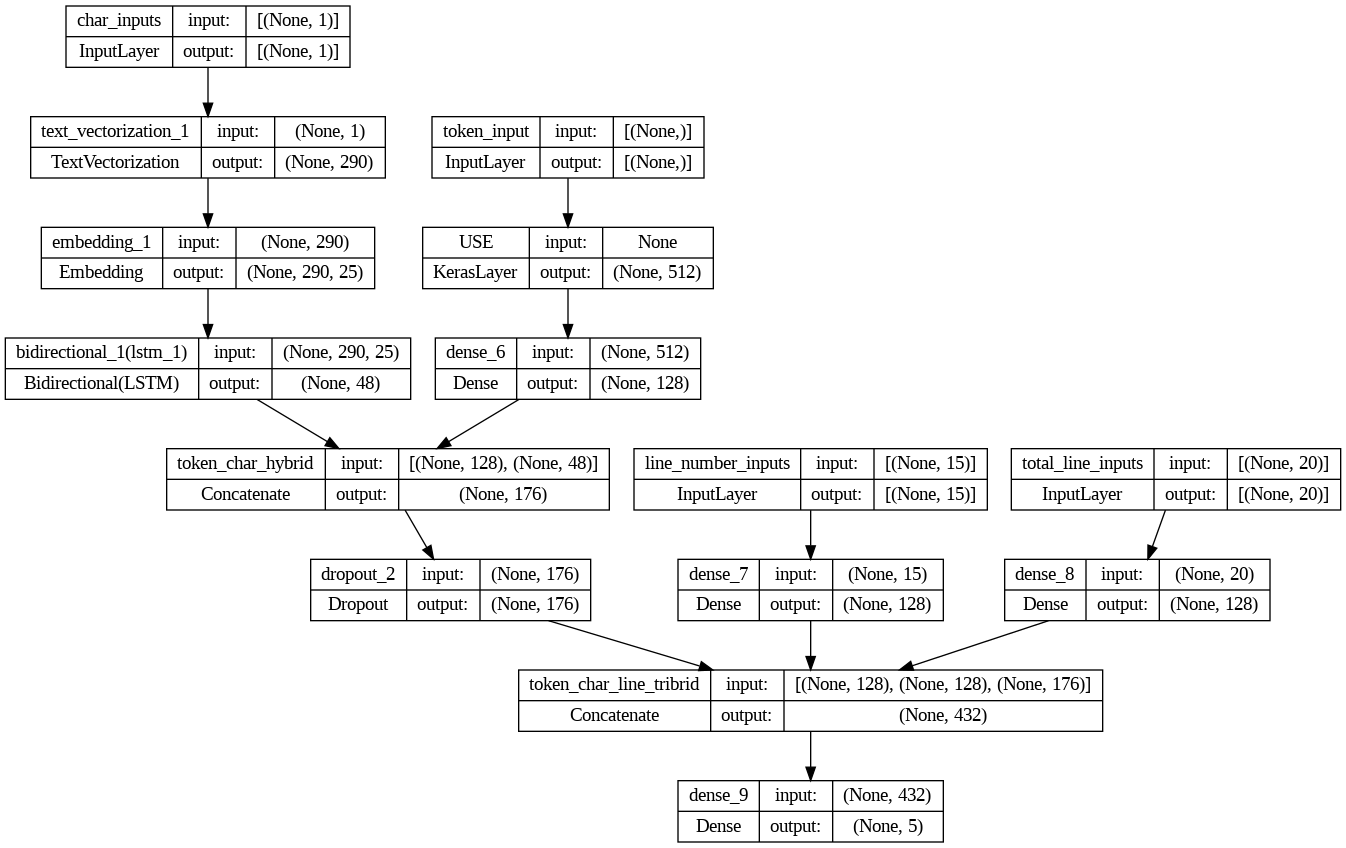

In [114]:
# Plot tribrid model
from tensorflow.keras.utils import plot_model
plot_model(model_5, show_shapes=True)

***What is label smoothing***

It may get stuck on the class with prediction probability is really high

What label smoothing does is it assigns some of the  value from the highestt pred prob to other classes, in turn, hopefully improving generalization

***Source**: for more on label smoothing: https://pyimagesearch.com/2019/12/30/label-smoothing-with-keras-tensorflow-and-deep-learning/

In [115]:
# Compile the model
model_5.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # 0.2 means 0.1 for label 0 and 0.9 for label 1
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


### Creating a Tribrid embedding datasett using tf.data

In [116]:
# Create char and sentences input tf dataset
train_char_token_lines_data = tf.data.Dataset.from_tensor_slices((train_sentences, 
                                                                  train_chars, 
                                                                  train_line_numbers_one_hot,
                                                                  train_total_lines_one_hot))
train_char_token_labels = tf.data.Dataset.from_tensor_slices(train_labels_one_hot)
train_char_token_lines_dataset = tf.data.Dataset.zip((train_char_token_lines_data, train_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

# Create for validation dataset
val_char_token_lines_data =tf.data.Dataset.from_tensor_slices((val_sentences, val_chars,
                                                               val_line_numbers_one_hot,
                                                               val_total_lines_one_hot))
val_char_token_labels = tf.data.Dataset.from_tensor_slices(val_labels_one_hot)
val_char_token_lines_dataset = tf.data.Dataset.zip((val_char_token_lines_data, val_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [117]:
# Fit the model
model_5_history = model_5.fit(
    train_char_token_lines_dataset,
    epochs=10,
    steps_per_epoch=int(0.1 * len(train_char_token_lines_dataset)),
    validation_data=val_char_token_lines_dataset,
    validation_steps=int(0.1 * len(val_char_token_lines_dataset))
)

Epoch 1/10
562/562 [==============================] - 48s 64ms/step - loss: 1.0874 - accuracy: 0.7270 - val_loss: 0.9851 - val_accuracy: 0.7985
Epoch 2/10
562/562 [==============================] - 38s 68ms/step - loss: 0.9801 - accuracy: 0.8082 - val_loss: 0.9593 - val_accuracy: 0.8198
Epoch 3/10
562/562 [==============================] - 41s 74ms/step - loss: 0.9693 - accuracy: 0.8116 - val_loss: 0.9559 - val_accuracy: 0.8198
Epoch 4/10
562/562 [==============================] - 35s 63ms/step - loss: 0.9585 - accuracy: 0.8240 - val_loss: 0.9494 - val_accuracy: 0.8245
Epoch 5/10
562/562 [==============================] - 32s 58ms/step - loss: 0.9586 - accuracy: 0.8258 - val_loss: 0.9407 - val_accuracy: 0.8381
Epoch 6/10
562/562 [==============================] - 33s 58ms/step - loss: 0.9610 - accuracy: 0.8207 - val_loss: 0.9369 - val_accuracy: 0.8381
Epoch 7/10
562/562 [==============================] - 35s 62ms/step - loss: 0.9503 - accuracy: 0.8306 - val_loss: 0.9389 - val_accuracy:

In [118]:
# our tribrid dataset
train_char_token_lines_dataset, val_char_token_lines_dataset

(<_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>,
 <_PrefetchDataset element_spec=((TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None,), dtype=tf.string, name=None), TensorSpec(shape=(None, 15), dtype=tf.float32, name=None), TensorSpec(shape=(None, 20), dtype=tf.float32, name=None)), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>)

In [119]:
# Evaluate our model
model_5.evaluate(val_char_token_lines_dataset)

945/945 [==============================] - 23s 24ms/step - loss: 0.9249 - accuracy: 0.8433


[0.9249424934387207, 0.8433403968811035]

In [120]:
# Making predictions
model_5_pred_probs = model_5.predict(val_char_token_lines_dataset)

945/945 [==============================] - 25s 23ms/step


In [121]:
model_5_preds = tf.argmax(model_5_pred_probs, axis=1)

In [122]:
model_5_results = calculate_results(val_labels_encoded, model_5_preds)

In [123]:
model_5_results

{'accuracy': 84.33403945452139,
 'precision': 0.843085645027463,
 'recall': 0.8433403945452138,
 'f1': 0.8409333177614339}

# Model 6: Tribrid Embedding Model + DAN

In [124]:
# Build TensorFlow Hub pretrained model embeddings
sentence_encoder_layer_transformer = hub.KerasLayer("https://tfhub.dev/google/universal-sentence-encoder-large/5",
                                        input_shape=[],
                                        dtype=tf.string,
                                        trainable=False,
                                        name='USE_Transformer')

 

In [125]:
# 1. Create a token-level model

token_input = layers.Input(shape=[],  dtype=tf.string, name='token_input')
token_embeddings = sentence_encoder_layer_transformer(token_input)
token_output = layers.Dense(128, activation='relu')(token_embeddings)
token_model = tf.keras.Model(token_input, token_output)

# Create a characacter level model 
char_inputs = layers.Input(shape=(1,), dtype=tf.string, name='char_inputs')
x = char_vectorizer(char_inputs)
x = char_embedding(x)
char_output = layers.Bidirectional(layers.LSTM(24))(x)
char_model = tf.keras.Model(char_inputs, char_output)

# 3. create a model for the line number feature
line_number_inputs = layers.Input(shape=(15,), name='line_number_inputs')
x = layers.Dense(128, activation='relu')(line_number_inputs)
line_number_model = tf.keras.Model(line_number_inputs, x)

# 4. Create a model for the total line number feature
total_line_inputs = layers.Input(shape=(20,), name='total_line_inputs') 
x = layers.Dense(128, activation='relu')(total_line_inputs)
total_line_model = tf.keras.Model(total_line_inputs, x)

# 5. Combine the outputs of 1 & 2 using tf.keras.layers.Concatenate
token_char_concat = layers.Concatenate(name='token_char_hybrid')([token_model.output,
                                                                  char_model.output])
# 5.1 Add LSTM layer
combined_dropout = layers.Dropout(0.5)(token_char_concat)

# 6. Combine the  output   of 3,4,5 
final_model_concat = layers.Concatenate(name='token_char_line_tribrid')([line_number_model.output,
                                                                         total_line_model.output,
                                                                         combined_dropout])
# 7.Create an output layer to accept the tribried embedding and output label probabilitites

output_layer = layers.Dense(5, activation='softmax')(final_model_concat)

# 8.combine the inputs of 1,2,3,4 and outputs of 7 into a tf.keras.Model
model_6 = tf.keras.Model(inputs=[token_model.input, char_model.input, line_number_model.input,
                                 total_line_model.input],
                         outputs=output_layer)

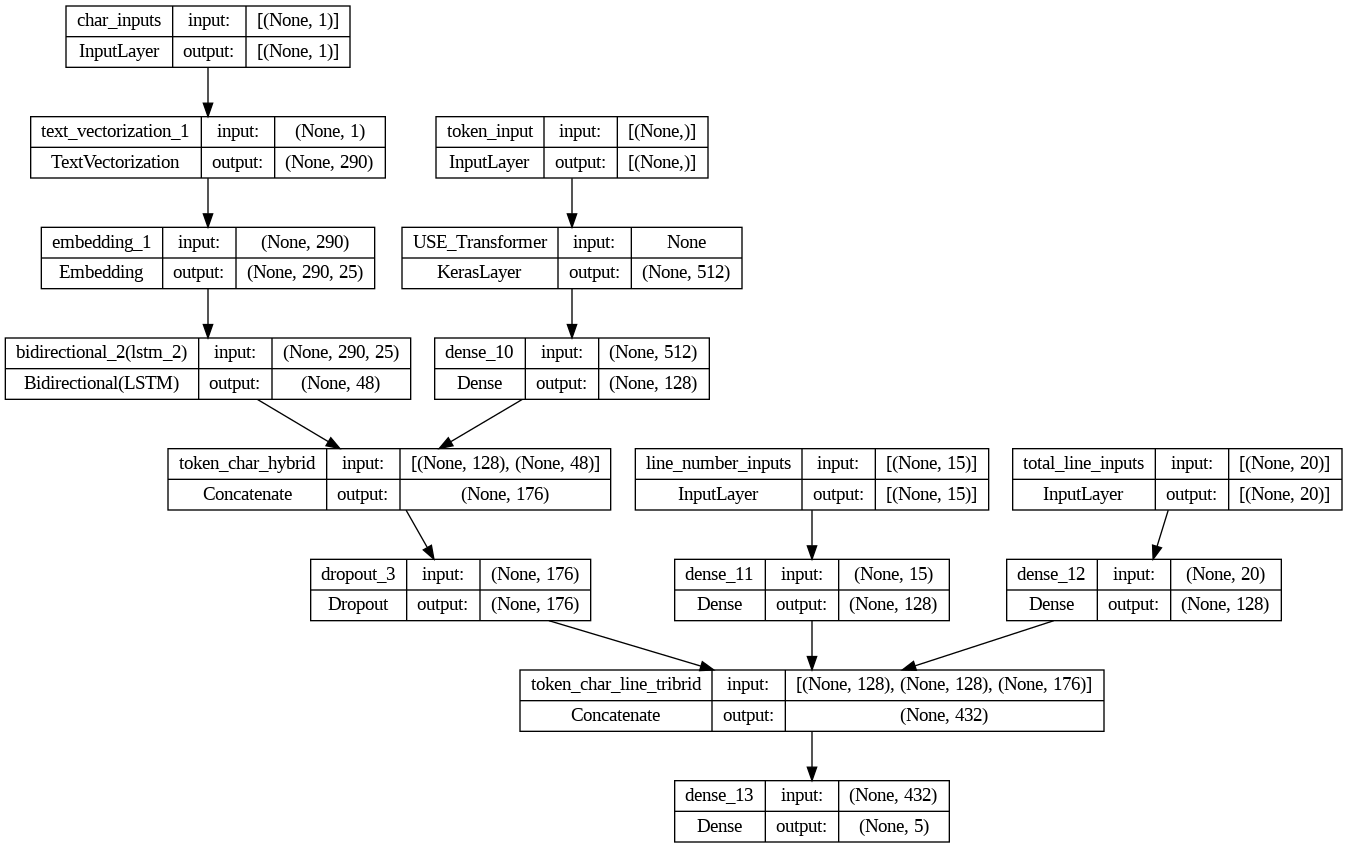

In [126]:
# Plot tribrid model
from tensorflow.keras.utils import plot_model
plot_model(model_6, show_shapes=True)

In [127]:
# Compile the model
model_6.compile(loss=tf.keras.losses.CategoricalCrossentropy(label_smoothing=0.2), # 0.2 means 0.1 for label 0 and 0.9 for label 1
                optimizer=tf.keras.optimizers.Adam(),
                metrics=['accuracy'])


In [128]:
# Fit the model
model_6_history = model_6.fit(
    train_char_token_lines_dataset,
    epochs=10,
    steps_per_epoch=int(0.1 * len(train_char_token_lines_dataset)),
    validation_data=val_char_token_lines_dataset,
    validation_steps=int(0.1 * len(val_char_token_lines_dataset))
)

Epoch 1/10
562/562 [==============================] - 102s 116ms/step - loss: 1.0678 - accuracy: 0.7484 - val_loss: 0.9592 - val_accuracy: 0.8172
Epoch 2/10
562/562 [==============================] - 57s 102ms/step - loss: 0.9571 - accuracy: 0.8251 - val_loss: 0.9359 - val_accuracy: 0.8368
Epoch 3/10
562/562 [==============================] - 54s 97ms/step - loss: 0.9393 - accuracy: 0.8356 - val_loss: 0.9288 - val_accuracy: 0.8441
Epoch 4/10
562/562 [==============================] - 63s 112ms/step - loss: 0.9311 - accuracy: 0.8458 - val_loss: 0.9219 - val_accuracy: 0.8358
Epoch 5/10
562/562 [==============================] - 56s 99ms/step - loss: 0.9321 - accuracy: 0.8446 - val_loss: 0.9165 - val_accuracy: 0.8484
Epoch 6/10
562/562 [==============================] - 61s 108ms/step - loss: 0.9346 - accuracy: 0.8368 - val_loss: 0.9121 - val_accuracy: 0.8511
Epoch 7/10
562/562 [==============================] - 65s 116ms/step - loss: 0.9257 - accuracy: 0.8501 - val_loss: 0.9116 - val_acc

In [129]:
# Making predictions
model_6.evaluate(val_char_token_lines_dataset)

model_6_pred_probs = model_6.predict(val_char_token_lines_dataset)

model_6_preds = tf.argmax(model_6_pred_probs, axis=1)

model_6_results = calculate_results(val_labels_encoded, model_6_preds)


945/945 [==============================] - 70s 65ms/step


## Compare our model Results

In [130]:
# Combine model results into a dataframe
all_model_results = pd.DataFrame({'model_0_baseline': baseline_results,
                                  'model_1_custom_token_embedding': model_1_results,
                                  'model_2_pretrained_token_embedding': model_2_results,
                                  'model_3_custom_char_embedding': model_3_results,
                                  'model_4_hybrid_char_token_embedding': model_4_results,
                                  'model_5_positional_char_token_embedding_DAN': model_5_results,
                                  'model_6_positional_char_token_embedding_transformer': model_6_results})

# all_model_results = all_model_results.transpose()
all_model_results = all_model_results.transpose()

all_model_results

,accuracy,precision,recall,f1
model_0_baseline,72.183238,0.783563,0.721832,0.744740
model_1_custom_token_embedding,81.345161,0.820827,0.813452,0.816229
model_2_pretrained_token_embedding,69.952337,0.715874,0.699523,0.705446
model_3_custom_char_embedding,34.085794,0.932419,0.340858,0.480187
model_4_hybrid_char_token_embedding,76.161790,0.773674,0.761618,0.765332
model_5_positional_char_token_embedding_DAN,84.334039,0.843086,0.843340,0.840933
model_6_positional_char_token_embedding_transformer,86.091619,0.860752,0.860916,0.858282


In [131]:
# Reduce the accuracy to same scale as other metrics
all_model_results['accuracy'] = all_model_results['accuracy'] / 100


<Axes: >

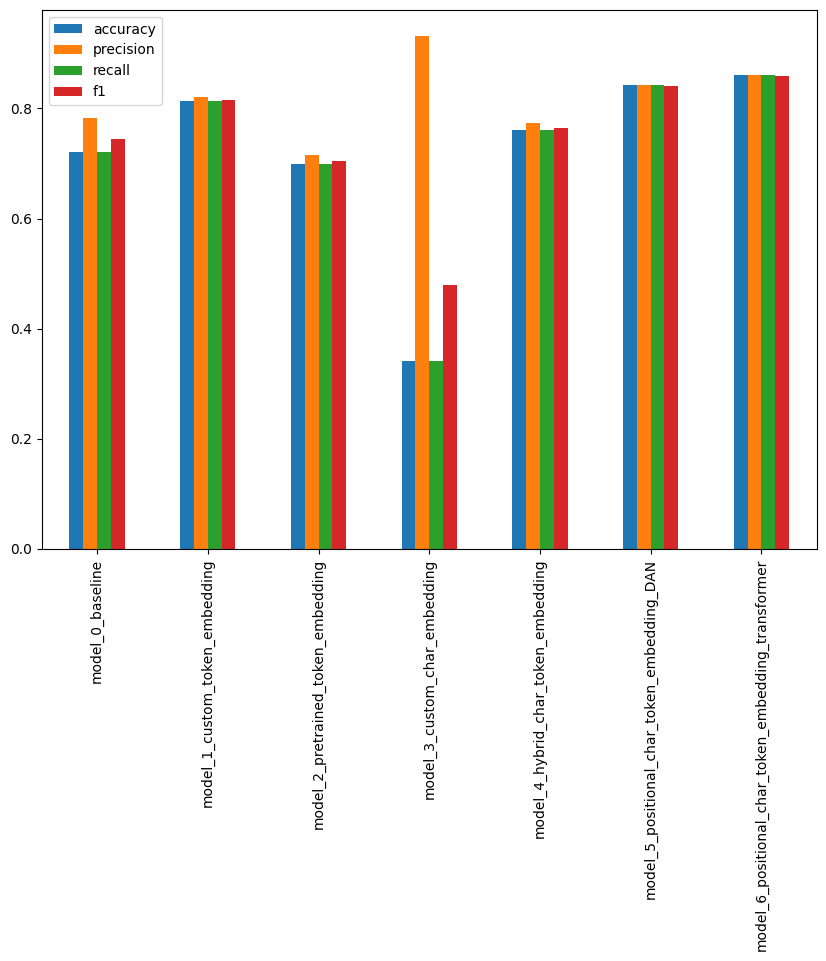

In [132]:
# Plot and compare all model results
all_model_results.plot(kind='bar', figsize=(10, 7))

<Axes: >

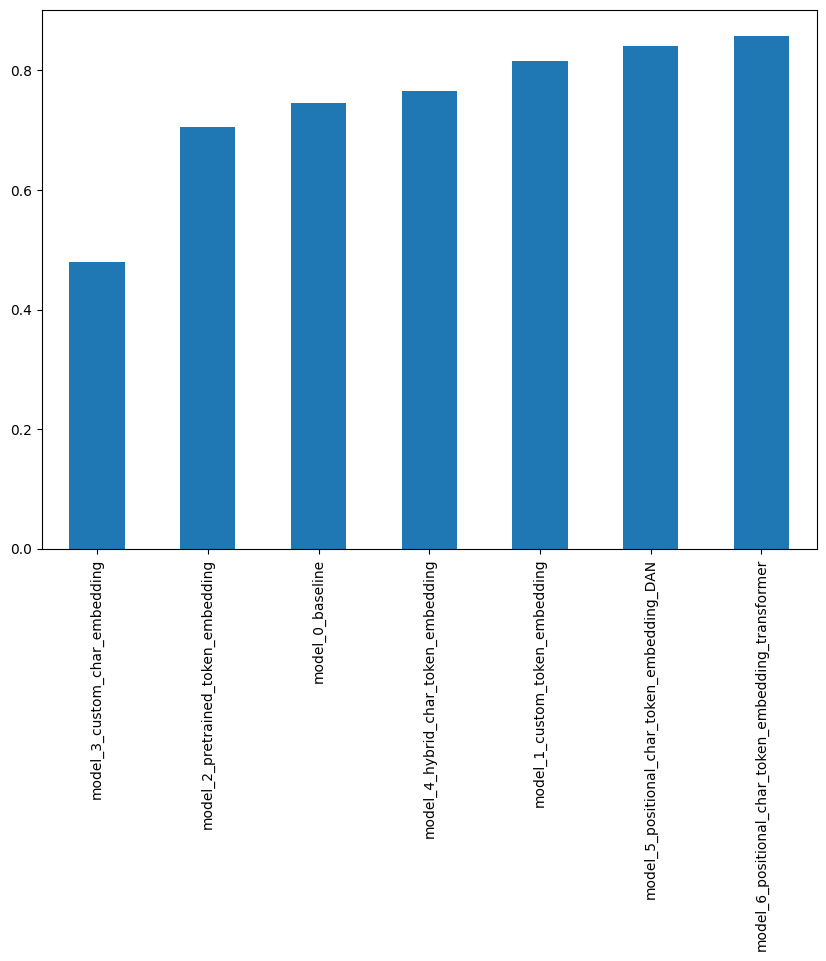

In [133]:
# Sort models results by f1-score
all_model_results.sort_values('f1', ascending=True)['f1'].plot(kind='bar', figsize=(10, 7))

# Save and load model

In [134]:
# SavedModel format (default)
model_5.save('skimlit_tribrid_model')

KeyboardInterrupt: ignored

In [ ]:
# Load in best performing model
loaded_model = tf.keras.models.load_model('/content/skimlit_tribrid_model')

In [ ]:
# Compare the original results to the loaded model
model_5_results

In [ ]:
loaded_pred_probs = loaded_model.predict(val_char_token_lines_dataset)
loaded_preds = loaded_pred_probs.argmax(axis=1)
loaded_preds[:5]

In [ ]:
# Calculate the results of our loaded model
loaded_model_results = calculate_results(y_true=val_labels_encoded,
                                         y_pred=loaded_preds)
loaded_model_results

In [ ]:
assert loaded_model_results == model_5_results

## Download and load in a pretrained model from google storage

In [ ]:
# !wget
# !mkdir
# !unzip

## Challenges
1. Turn the test data samples into a tf.data.Dataset (fast loading) and then evaluate (make predictions) the best performing model on the test samples
2. Find the most wrong predictions from 1 (these are the samples where the model has predicted the wrong label with the highest prediction probability).
3. Make example predictions (on RCT abstracts from the wild),
4. See the exercises and extra curriculum section on GitHub to further test your skills (section 09)

In [ ]:
# 1. Turn the test data samples into a tf.data.Dataset
# Create for validation dataset
test_char_token_lines_data =tf.data.Dataset.from_tensor_slices((test_sentences, test_chars,
                                                               test_line_numbers_one_hot,
                                                               test_total_lines_one_hot))
test_char_token_labels = tf.data.Dataset.from_tensor_slices(test_labels_one_hot)
test_char_token_lines_dataset = tf.data.Dataset.zip((test_char_token_lines_data, test_char_token_labels)).batch(32).prefetch(tf.data.AUTOTUNE)

In [ ]:
# Find the most wrong predictions from 1


In [ ]:
import numpy as np

np.sqrt(0.3946)